In [1]:
import pandas as pd
mutations_path = "mutations"
mutations_df = pd.read_csv(mutations_path, sep='\t', index_col=0)

In [2]:
mutations_df.head()

,chr,start,end,reference,alt,gene,effect,Amino_Acid_Change,DNA_VAF,SIFT,PolyPhen
sample,,,,,,,,,,,
TCGA-2A-A8VL-01,10,29775061,29775061,C,T,SVIL,Missense_Mutation,p.D1578N,0.15,deleterious(0.01),benign(0.082)
TCGA-2A-A8VL-01,11,105948438,105948438,A,C,AASDHPPT,Translation_Start_Site,p.M1?,0.16,tolerated_low_confidence(0.21),benign(0.267)
TCGA-2A-A8VL-01,11,18460141,18460141,C,T,LDHC,Missense_Mutation,p.T220M,0.28,deleterious(0.04),possibly_damaging(0.852)
TCGA-2A-A8VL-01,11,55606971,55606971,T,A,OR5D16,Silent,p.T248T,0.15,NaN,NaN
TCGA-2A-A8VL-01,11,6541310,6541310,C,T,DNHD1,Missense_Mutation,p.S588F,0.26,NaN,benign(0.019)


Build a Binary Mutation Matrix
create a matrix where rows: patients(sample IDs), columns: genes, values=1 if gene is mutated, else 0

In [3]:
# Step 1: Reset index to expose 'sample' as a column
mutations_df = mutations_df.reset_index()

# Step 2: Rename the gene column to standardize
mutations_df = mutations_df.rename(columns={"gene": "Gene"})

# Step 3: Create binary matrix: 1 if gene is mutated in patient, else 0
mutation_matrix = (
    mutations_df[['sample', 'Gene']]
    .drop_duplicates()
    .assign(present=1)
    .pivot(index='sample', columns='Gene', values='present')
    .fillna(0)
    .astype(int)
)

# Preview
mutation_matrix.shape, mutation_matrix.head()

((495, 12677),
 Gene             A1BG  A1CF  A2M  A2ML1  A4GALT  AACSP1  AADAC  AADACL3  \
 sample                                                                    
 TCGA-2A-A8VL-01     0     0    0      0       0       0      0        0   
 TCGA-2A-A8VO-01     0     0    0      0       0       0      0        0   
 TCGA-2A-A8VT-01     0     0    0      0       0       0      0        0   
 TCGA-2A-A8VV-01     0     0    0      0       0       0      0        0   
 TCGA-2A-A8VX-01     0     0    0      0       0       0      0        0   
 
 Gene             AADACL4  AADAT  ...  ZSWIM4  ZSWIM5  ZSWIM8  ZW10  ZWILCH  \
 sample                           ...                                         
 TCGA-2A-A8VL-01        0      0  ...       0       0       0     0       0   
 TCGA-2A-A8VO-01        0      0  ...       0       0       0     0       0   
 TCGA-2A-A8VT-01        0      0  ...       0       0       0     0       0   
 TCGA-2A-A8VV-01        0      0  ...       0       0   

Next, align with response labels, pull the response column from clinical_df, align with mutation_matrix.index, filter both to include only samples that exist in both

In [4]:
# If clinical_df isn't already loaded, reload it
clinical_df = pd.read_csv("phenotype", sep="\t", index_col=0)

# Prepare response vector
label_col = 'primary_therapy_outcome_success'
clinical_df[label_col] = clinical_df[label_col].fillna("Missing")
clinical_df['response'] = clinical_df[label_col].apply(lambda x: 1 if 'Complete' in str(x) else 0)

# Align response with mutation matrix
mutation_matrix.index = mutation_matrix.index.str[:15]  # Truncate if needed
common_ids = mutation_matrix.index.intersection(clinical_df.index)

X_mut = mutation_matrix.loc[common_ids]
y_mut = clinical_df.loc[common_ids, 'response']

# Final shapes
X_mut.shape, y_mut.shape

((495, 12677), (495,))

x_mut=feature_matrix, 495 patients x 12,677 genes (each gene is a binary feature, mutated or not 0 or 1)
y_mut=response vector, 495 binary labels, 0=non responder, 1=complete responder

NOW: train test split for mutation model

In [5]:
from sklearn.model_selection import train_test_split

# Stratified split: 80% train, 20% test
X_train_mut, X_test_mut, y_train_mut, y_test_mut = train_test_split(
    X_mut, y_mut, test_size=0.2, stratify=y_mut, random_state=42
)

# Check distribution
y_train_mut.value_counts(normalize=True), y_test_mut.value_counts(normalize=True)

(response
 1    0.681818
 0    0.318182
 Name: proportion, dtype: float64,
 response
 1    0.676768
 0    0.323232
 Name: proportion, dtype: float64)

stratified correctly, now we have X_train_mut, y_train_mut for training and X_test_mut and Y_test_mut for performance evaluation

NEXT STEP: train a random forest on mutation data

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Instantiate model
rf_mut = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train model
rf_mut.fit(X_train_mut, y_train_mut)

# Predict
y_pred_proba = rf_mut.predict_proba(X_test_mut)[:, 1]
y_pred_class = rf_mut.predict(X_test_mut)

# Evaluate
auc = roc_auc_score(y_test_mut, y_pred_proba)
print(f"AUC: {auc:.3f}")
print("\nClassification Report:\n", classification_report(y_test_mut, y_pred_class))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_mut, y_pred_class))


AUC: 0.571

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.67      0.99      0.80        67

    accuracy                           0.67        99
   macro avg       0.34      0.49      0.40        99
weighted avg       0.46      0.67      0.54        99


Confusion Matrix:
 [[ 0 32]
 [ 1 66]]


ALL 32 non responders are misclassified, only 1 responder , model classifies nearly EVERYTHING as a responder, FALSE positive rate very high

Causes: for prostate cancer, ICI response may be less mutation driven and more about tumor microenvironment and expression-level immune activity, mutation features dont encode enough response info here
too many sparse features: 12,677 binary columns, most are 0 for most patients, creates noise, sparsity, and high variance, many genes mutated in only 1-2 patients, adding randomness

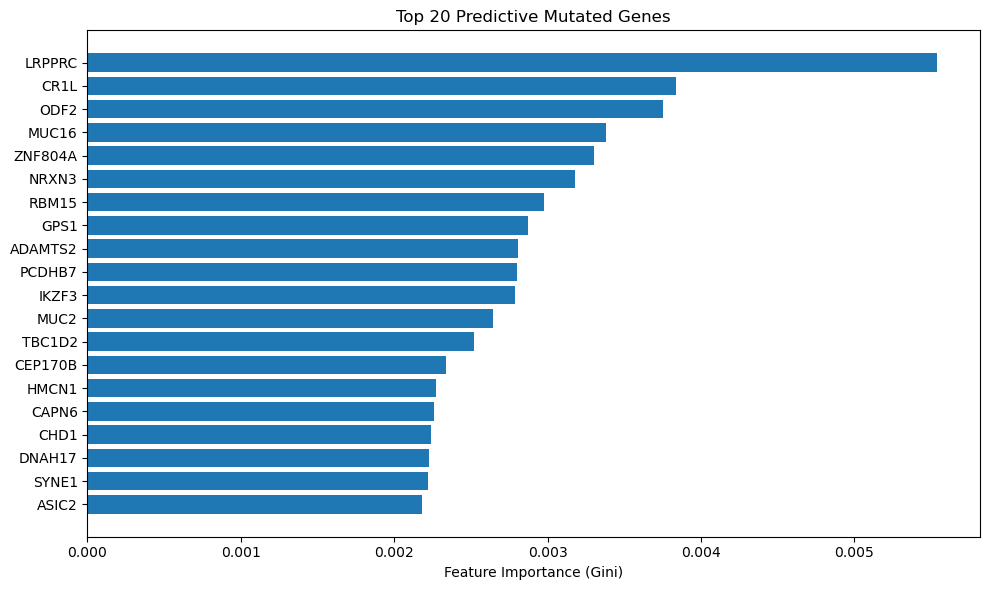

,Gene,Importance
6063,LRPPRC,0.005542
2435,CR1L,0.003836
7382,ODF2,0.003751
6753,MUC16,0.003378
12601,ZNF804A,0.003305
7269,NRXN3,0.003177
8981,RBM15,0.002976
4456,GPS1,0.002871
228,ADAMTS2,0.002804
7881,PCDHB7,0.002799


In [7]:
import matplotlib.pyplot as plt

# Get importances
importances = rf_mut.feature_importances_
genes = X_train_mut.columns

# Create DataFrame and sort
importance_df = pd.DataFrame({
    'Gene': genes,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 20 genes
top_genes = importance_df.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_genes['Gene'][::-1], top_genes['Importance'][::-1])
plt.xlabel("Feature Importance (Gini)")
plt.title("Top 20 Predictive Mutated Genes")
plt.tight_layout()
plt.show()

# Also print the table
top_genes

Conclusion: model might be picking up statistical noise from rare mutations, overfitting to low-frequency events, or gene mutations co-occurruing by chance in responders
Solution: Filter and Re-train(restriuct modeling to a curated subset of biologically meaningful genes such as: COSMIC cancer genes or genes mutated in >=5% of your cohort, or prostate-specific drivers(in TCGA-PRAD))

Step 1: filter to frequently mutated genes

In [11]:
# Step 1: Filter mutation features (genes mutated in ≥ 5% of samples)
gene_counts = X_mut.sum(axis=0)
frequent_genes = gene_counts[gene_counts >= (0.05 * len(X_mut))].index  # 5% threshold
X_mut_filtered = X_mut[frequent_genes]

# Step 2: Split again
X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(
    X_mut_filtered, y_mut, test_size=0.2, stratify=y_mut, random_state=42
)

# Step 3: Retrain RF
rf_filt = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_filt.fit(X_train_filt, y_train_filt)

# Step 4: Predict + Evaluate
y_probs_filt = rf_filt.predict_proba(X_test_filt)[:, 1]
y_preds_filt = rf_filt.predict(X_test_filt)

auc_filt = roc_auc_score(y_test_filt, y_probs_filt)
print(f"AUC: {auc_filt:.3f}")
print("\nClassification Report:\n", classification_report(y_test_filt, y_preds_filt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_filt, y_preds_filt))


AUC: 0.617

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.47      0.46        32
           1       0.74      0.73      0.74        67

    accuracy                           0.65        99
   macro avg       0.60      0.60      0.60        99
weighted avg       0.65      0.65      0.65        99


Confusion Matrix:
 [[15 17]
 [18 49]]


In [12]:
#MAKE OWN CURATED LIST of GENES I KNOW TO DRIVE PROSTATE CANCER
cosmic_genes = [
    'TP53', 'SPOP', 'FOXA1', 'CHD1', 'PTEN', 'ARID1A', 'PIK3CA', 'CDK12', 
    'RB1', 'NKX3-1', 'ATM', 'ZBTB16', 'BRCA2', 'AKT1', 'SMAD4', 'MTOR'
]

# Intersect gene list with your mutation matrix
cosmic_present = [g for g in cosmic_genes if g in X_mut.columns]
X_mut_cosmic = X_mut[cosmic_present]

# Train/test split
X_train_cos, X_test_cos, y_train_cos, y_test_cos = train_test_split(
    X_mut_cosmic, y_mut, test_size=0.2, stratify=y_mut, random_state=42
)

# Train Random Forest
rf_cos = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_cos.fit(X_train_cos, y_train_cos)

# Predict + Evaluate
y_probs_cos = rf_cos.predict_proba(X_test_cos)[:, 1]
y_preds_cos = rf_cos.predict(X_test_cos)

auc_cos = roc_auc_score(y_test_cos, y_probs_cos)
print(f"AUC: {auc_cos:.3f}")
print("\nClassification Report:\n", classification_report(y_test_cos, y_preds_cos))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_cos, y_preds_cos))


AUC: 0.579

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.34      0.38        32
           1       0.71      0.78      0.74        67

    accuracy                           0.64        99
   macro avg       0.57      0.56      0.56        99
weighted avg       0.62      0.64      0.63        99


Confusion Matrix:
 [[11 21]
 [15 52]]
